# True Zonal Mean

Calculate the *true zonal mean* of a scalar quantity regardless of the horizontal mesh. 

Specifically, we calculate the volume weighted mean along all grid cells whose centres fall within finite latitude intervals rather than the arithmetic mean of cells along the model's curvilinear grid. The method presented can also be used to re-grid models onto the same latitudinal grid and the general principles can be used to define any multidimensional sum or average using the `xhistogram` package.
    
**Requirements:** 
Select the `conda/analysis3-24.02` (or later) kernel.
This code should work for just about any MOM5 configuration since all we are grabbing is temeprature and standard grid information. You can swap temperature with any other scalar variable. You can also in principle swap latitude with another scalar.

#### Adapting for MOM6

|Variable | MOM5 diagnostic | Equivalent MOM6 diagnostic | 
|:--------|-----|------|
| Temperature | `temp` (conservative temperature) | `thetao` (potential temperature) | 
| Cell volume (m3) | `area_t * dzt` | `volcello` | 
| Lat, lon | `geolon_t`, `geolat_t` | `geolon_t`, `geolat_t` | 

Note that the available MOM6 experiments from the COSIMA community are from a PanAntarctic model and thus limited to the Southern Ocean.

## MOM5

In [1]:
import intake
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
from dask.distributed import Client
from xhistogram.xarray import histogram 

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33281,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35803,Total threads: 1
Dashboard: /proxy/41503/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44589,


Open ACCESS-NRI's default catalog:

In [3]:
catalog = intake.cat.access_nri

Choose the experiment and the variable we want to average. This example uses temperature but you can choose any scalar, 3D variable. The variables `dzt` and `area_t` are also required so we can only use experiments that save those:

In [4]:
catalog.search(name='.*025deg_jra55.*', variable=["temp", "dzt", "area_t"])

,model,description,realm,frequency,variable
name,,,,,
025deg_jra55_iaf_era5comparison,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0\ninterannual forcing (1980-2019)},{ocean},"{1mon, fx}","{temp, area_t}"
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},"{1mon, fx}","{temp, area_t}"
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},"{1mon, fx}","{temp, area_t}"
025deg_jra55_iaf_omip2_cycle3,{ACCESS-OM2},{Cycle 3/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},"{1mon, fx}","{temp, area_t}"
025deg_jra55_iaf_omip2_cycle4,{ACCESS-OM2},{Cycle 4/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},"{1mon, fx}","{temp, area_t}"
025deg_jra55_iaf_omip2_cycle5,{ACCESS-OM2},{Cycle 5/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},"{1mon, fx}","{temp, area_t}"
025deg_jra55_iaf_omip2_cycle6,{ACCESS-OM2},{Cycle 6/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},{ocean},"{1mon, fx}","{temp, area_t}"
025deg_jra55_ryf9091_gadi,{ACCESS-OM2},{0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},{ocean},"{fx, 1mon, 1yr}","{temp, area_t, dzt}"
025deg_jra55_ryf_era5comparison,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0\nRYF9091 repeat year forcing (May 1990 to Apr 1991)},{ocean},"{1mon, fx}","{temp, area_t, dzt}"


In [5]:
experiment = '025deg_jra55_ryf9091_gadi' #Choose any run (that includes the required variables)
variable = 'temp' #any scalar variable where volume weighted averaging makes sense

xarray_open_kwargs=dict(use_cftime=True, chunks={"time": -1}, decode_timedelta=False)

In [6]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable=variable, frequency="1yr")
variable_to_average = var_search.to_dask(xarray_open_kwargs=xarray_open_kwargs)[variable]
variable_to_average

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.DataArray 'temp' (time: 396, st_ocean: 50, yt_ocean: 1080,
                          xt_ocean: 1440)> Size: 123GB
dask.array<concatenate, shape=(396, 50, 1080, 1440), dtype=float32, chunksize=(2, 10, 216, 288), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * st_ocean  (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * time      (time) object 3kB 1904-07-02 12:00:00 ... 2299-07-02 12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

First we show the standard approach, which is to take the arithmetic mean of all grid cells along the quasi-longitudinal coordinate. For MOM5's tri-polar grid this approach is in principle "okay" for the southern hemisphere, where grid cell areas are constant at fixed latitude. It doesn't though, take into account partial cells.

The `xarray`'s method `.mean(dim='dimension')` applies `numpy.mean()` across that dimension. This is simply the arithmetic mean.

For some scalar $T$ the arithmetic mean, e.g., across dimension `i`, is given by

$$ \left<T\right>_{j,k} = \frac{1}{I}\sum_{i=1}^{I} T_{i,j,k},$$

where $i$, $j$ and $k$ are the indicies in the $x$, $y$ and $z$ directions respectively of the curvilinear grid and $I$ is the number of indicies along the $x$ axis. 

CPU times: user 2.05 s, sys: 246 ms, total: 2.3 s
Wall time: 2.6 s


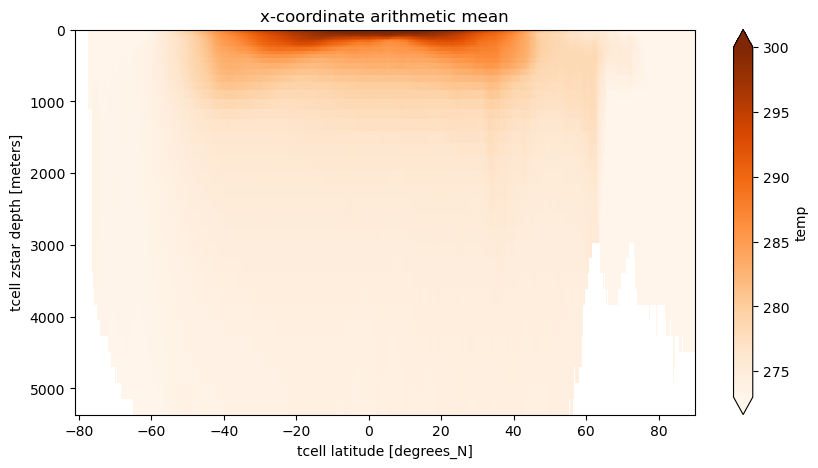

In [7]:
%%time
x_arith_mean = variable_to_average.groupby('time.year').mean(dim='time').mean(dim='xt_ocean')

plt.figure(figsize=(10, 5))
x_arith_mean.sel(year=2000).plot(yincrease=False, vmin=273, vmax=300, cmap='Oranges')
plt.title('x-coordinate arithmetic mean');

The main issue with this average is that the 'latitude' coordinate may be meaningless near the north pole, particularly when comparing to observational analyses or other models which can have either a regular grid or a different curvilinear grid. Even different versions of MOM might have different grids! 

Let us consider what the true zonal average looks like. That is consider a set of latitude 'edges' $\{\phi'_{1/2},\phi'_{1+1/2},...,\phi'_{\ell-1/2},\phi'_{\ell+1/2},...,\phi'_{L+1/2}\}$ between which we want to compute an average of $T$ at $\{\phi'_{1},\phi'_{2},...,\phi'_{\ell},...,\phi'_{L}\}$ such that

$$ \overline{T}(\phi'_\ell,\sigma) = \dfrac{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}} T(\phi,\lambda,\sigma)\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A}{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}}\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A},$$

where $\lambda$ is longitude and $\sigma$ is an arbitrary vertical coordinate. 

In discrete form this average is

$$\overline{T}_{\ell,k} = \frac{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j}T_{i,j,k}\Delta Z_{i,j,k}\Delta \mathrm{Area}_{i,j}}{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j,k}\Delta Z_{i,j,k}\Delta \mathrm{Area}_{i,j}},$$

where $\delta_{i,j} = 1$ if $\phi'_{\ell-1/2}<\phi_{i,j}\leq \phi'_{\ell+1/2}$ and $\delta_{i,j} = 0$ elsewhere, $\Delta Z$ is the grid cell vertical thickness and $\Delta \mathrm{Area}$ is the grid cell horizontal area.

For our purposes we will use the edges of the models `xt_ocean` coordinate to define $\phi'_{\ell+1/2}$ so the number of 'bins' $L$ will be the same as the length of the quasi-latitude coordinate ($J$). 

Fortunately, as you can see below, the two sums are weighted histograms (one for $T$ times volume and the other for just volume) and these can be rapidly computed using `xhistogram`.

First lets load the scalar variable (latitude) we want to use as our coordinate then define the bin edges.

In [8]:
coord = 'geolat_t' #can be any scalar (2D, 3D, eulerian, lagrangian etc)

var_search = cat_subset.search(variable=coord, frequency='fx')
variable_as_coord = var_search.to_dask(xarray_open_kwargs=dict(use_cftime=True))[coord]
variable_as_coord

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.DataArray 'geolat_t' (yt_ocean: 1080, xt_ocean: 1440)> Size: 6MB
dask.array<open_dataset-geolat_t, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
Attributes:
    long_name:     tracer latitude
    units:         degrees_N
    valid_range:   [-91.  91.]
    cell_methods:  time: point

Now we want to define the coordinate bins as the latitude edges of the t-cells, adding the first edge (0) at latitude -90:

In [9]:
# Define the coordinate bins as the latitude edges of the T-cells
var_search = cat_subset.search(variable='geolat_c', frequency='fx')
yu_ocean = var_search.to_dask(xarray_open_kwargs=dict(use_cftime=True))['yu_ocean']

# make numpy array (using .values) and add 1st edge at -90
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 

# Alternatively we could just use some regular grid like this 
# bins =  np.linspace(-80, 90, 50)
# or use a grid from a different (coarser) model.

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Get the thickness, area a volume of cells

In [10]:
var_search = cat_subset.search(variable='dzt', frequency="1yr")
dzt = var_search.to_dask(xarray_open_kwargs=xarray_open_kwargs)['dzt'] #thickness of cells

var_search = cat_subset.search(variable='area_t', frequency='fx') # As above
area_t = var_search.to_dask(xarray_open_kwargs=dict(use_cftime=True))['area_t'] #area of cells

dVol = dzt * area_t #Volume of cells

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid

Now let's compute the numerator and denominator of the equation above using `xhistogram`, then the time mean and then the zonal mean.

In [11]:
histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins=[bins], weights=dVol, dim=['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins=[bins], weights=dVol * variable_to_average, dim=['yt_ocean', 'xt_ocean'])
coord_mean = (histTVolCoordDepth/histVolCoordDepth).groupby('time.year').mean(dim='time')

Now we can plot the results which thankfully retain all the data-array info on variables and axis etc.

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.63 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
 

CPU times: user 5.53 s, sys: 579 ms, total: 6.11 s
Wall time: 6.38 s


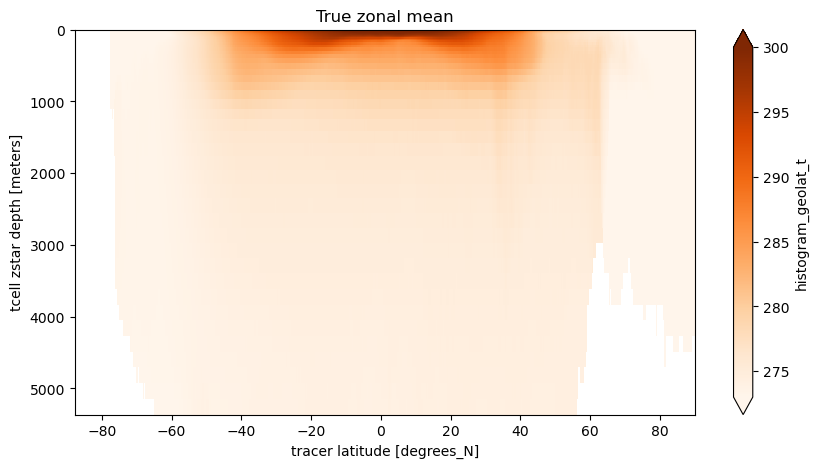

In [12]:
%%time

plt.figure(figsize=(10, 5))
coord_mean.sel(year=2000).plot(yincrease=False, vmin=273, vmax=300, cmap='Oranges')
plt.title('True zonal mean');

Since we used the same bin edges as the standard `yt_ocean` coordinate we can take a difference between the arithmetic mean along the model's x-axis and our mean along grid cells within latitude bands. The main differences are near the North Pole where the grid is furthest for being regular. There are also differences near the Antacrtic Shelf suggesting partial cells also matter.

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
 

CPU times: user 6.89 s, sys: 689 ms, total: 7.57 s
Wall time: 7.91 s


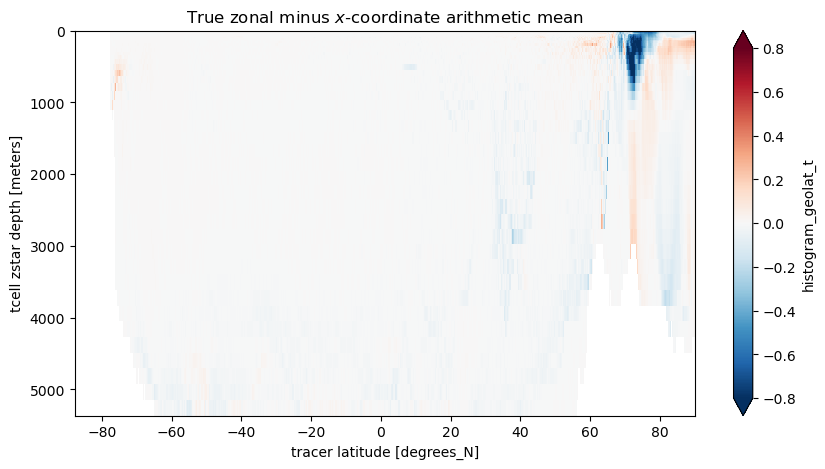

In [13]:
%%time

zonal_minus_x_mean = coord_mean.sel(year=2000) - x_arith_mean.sel(year=2000).values

plt.figure(figsize=(10, 5))
zonal_minus_x_mean.plot(yincrease=False, vmin=-0.8, vmax=0.8, cmap='RdBu_r', extend='both')
plt.title('True zonal minus $x$-coordinate arithmetic mean');

`xarray` has a new `weighted` functionality which allows it to do weighted means instead of arithmetic mean.

Let's see how that works out... We chose `dVol` as the weights and we only do the comparison for year 2000.

In [14]:
variable_to_average_weighted = variable_to_average.copy().sel(time='2000').mean(dim='time')
variable_to_average_weighted = variable_to_average_weighted.weighted(dVol.sel(time='2000').fillna(0))
meanweighted_y2000 = variable_to_average_weighted.mean(dim='xt_ocean').groupby('time.year').mean(dim='time').sel(year=2000)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
 

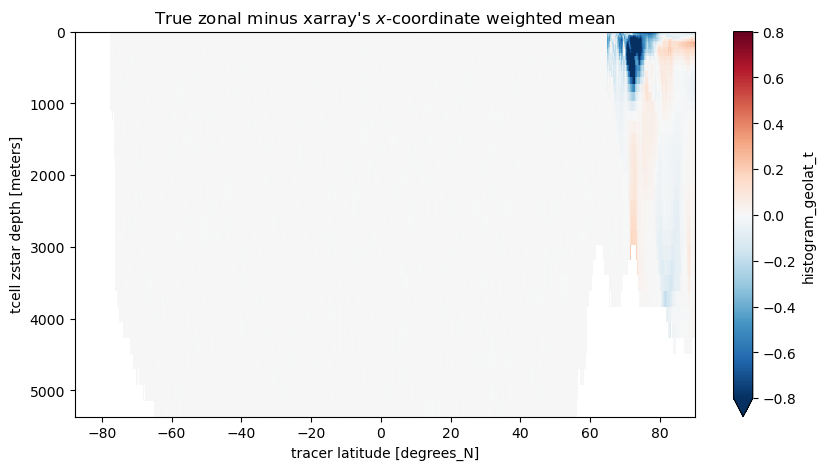

In [15]:
zonal_minus_x_mean = coord_mean.sel(year=2000) - meanweighted_y2000.values

plt.figure(figsize=(10, 5))
zonal_minus_x_mean.plot(yincrease=False, vmin=-0.8, vmax=0.8, cmap='RdBu_r')
plt.title("True zonal minus xarray's $x$-coordinate weighted mean");    

South of 65N, where complications of the tripolar grid don't matter, `xarray`'s weighted mean does the job! But in the region of the tripolar we need to be more careful.

In [16]:
client.close()